In [1]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
from qiskit.circuit.library import MCXGate
from walsh import *
from sequential import *
from primitives import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

## Walsh qsp

In [4]:
def walsh_circuit_qsp(n,n_ancilla_qsp,f,walsh_info,gray_code=True):
    """Generates the quantum circuit implementing the Walsh decomposition of function f with the Walsh operators
        whose orders are contain in walsh_info
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    n_ancilla_qsp : int
        Number of ancilla qubits used to control the rotations gates
    f : function
        Function of one variable
    walsh_info : dict
        Output of function walsh_informations, it is a dictionnary whose keys are the order of Walsh functions to implement and the
        values are the associated coefficients
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Walsh operators
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    a_qsp = AncillaRegister(n_ancilla_qsp+1,name='a_qsp')
    qc = QuantumCircuit(q,a_qsp)
    
    q_qubits = qc.qubits[:n]
    a_qsp_qubits = qc.qubits[n:]
    
    walsh_operators_list = []
    order_list = list(walsh_info.keys())
    for order in order_list:
        if gray_code:
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order],cnots=False))
        else:
            walsh_operators_list.append(walsh_operator(n,order,walsh_info[order]))
    qsp_control_index = 0
    for index,operator in enumerate(walsh_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            rotation_index = first_one_bit(int_to_binary(order_list[index],n,reverse=False))
            if index == 0:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            elif index > 0:
                previous_cnots_index = other_one_bits(int_to_binary(order_list[index-1],n,reverse=False))
                current_cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                if len(previous_cnots_index) > len(current_cnots_index):
                    cnots_index = list(set(previous_cnots_index)-set(current_cnots_index))
                else:
                    cnots_index = list(set(current_cnots_index)-set(previous_cnots_index))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index])
                qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            if index == len(walsh_operators_list)-1:
                cnots_index = other_one_bits(int_to_binary(order_list[index],n,reverse=False))
                for j in cnots_index:
                    qc.cx(q[j],q[rotation_index]) 
        else:
            qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
        qsp_control_index = (qsp_control_index+1)%(n_ancilla_qsp+1)
    return qc

In [8]:
def f(x):
    return np.sin(2*np.pi*x)

n = 3
n_ancilla_adjustable = 6
n_ancilla_qsp = 0
gray_code = True

q = QuantumRegister(n,name='q')
qA = QuantumRegister(1,name='qA')
a = AncillaRegister(n_ancilla_adjustable,name='a')
a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
qc = QuantumCircuit(qA,q,a,a_qsp)

qA_qubits = qc.qubits[:1]
q_qubits = qc.qubits[1:n+1]
a_qubits = qc.qubits[n+1:n+1+n_ancilla_adjustable]
a_qsp_qubits = qc.qubits[n+1+n_ancilla_adjustable:n+1+n_ancilla_adjustable+n+1+n_ancilla_qsp]

'''
q_qubits = qc.qubits[:n]
qA_qubits = qc.qubits[n:n+1]
a_qubits = qc.qubits[n+1:n+1+n_ancilla_adjustable]
a_qsp_qubits = qc.qubits[n+1+n_ancilla_adjustable:n+1+n_ancilla_adjustable+n_ancilla_qsp]
'''

old_qc_qubits = q_qubits+a_qubits

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])
        
qc.h(qA)
qc.h(q)

# copy of qA
copy_gate_qsp = copy(qA,a_qsp)
qc.append(copy_gate_qsp,qA_qubits+a_qsp_qubits)

# copy of main register
if n_ancilla_adjustable >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,q_qubits+a_qubits)

list_operator_to_implement = [i for i in range(2**n)]
n_blocks = get_n_blocks(n,n_ancilla_adjustable)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
walsh_info = walsh_informations(n,list_operator_to_implement,f,gray_code=gray_code)
for i in range(0,n_blocks):
    walsh_info_block = dict(list(walsh_info.items())[:n_operator_per_block_list[i]])
    qc.append(walsh_circuit_qsp(n,n_ancilla_qsp,f,walsh_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qA_qubits+a_qsp_qubits)
    walsh_info = dict(list(walsh_info.items())[n_operator_per_block_list[i]:])
    #qc.barrier()

# undo copy of main register
if n_ancilla_adjustable >= n:
    qc.append(copy_gate.inverse(),q_qubits+a_qubits)

# undo copy of qA
qc.append(copy_gate_qsp.inverse(),qA_qubits+a_qsp_qubits)

#qc.h(qA)
#qc.p(-np.pi/2,qA)

for i in range(int(n/2)):
    qc.swap(q[i],q[n-i-1])

qc.decompose().decompose().draw()

┌─────────────┐                                                       »
 qA: ┤ U3(π/2,0,π) ├───────────────────────────────────────────────────────»
     └─────────────┘     ┌───┐          ┌─────────────┐                    »
q_0: ─────────────────■──┤ X ├───────■──┤ U3(π/2,0,π) ├─────────────────■──»
     ┌─────────────┐  │  └─┬─┘       │  └─────────────┘                 │  »
q_1: ┤ U3(π/2,0,π) ├──┼────┼────■────┼─────────■────────────────────────┼──»
     └─────────────┘┌─┴─┐  │    │  ┌─┴─┐       │       ┌─────────────┐  │  »
q_2: ───────────────┤ X ├──■────┼──┤ X ├───────┼───────┤ U3(π/2,0,π) ├──┼──»
                    └───┘       │  └───┘       │       └─────────────┘┌─┴─┐»
a_0: ───────────────────────────┼──────────────┼──────────────────────┤ X ├»
                              ┌─┴─┐            │                      └───┘»
a_1: ─────────────────────────┤ X ├────────────┼───────────────────────────»
                              └───┘            │                           »
a_2: ──────────────────────────────────────────┼───────────────────────────»
                                               │                           »
a_3: ──────────────────────────────────────────┼───────────────────────────»
                                             ┌─┴─┐                         »
a_4: ────────────────────────────────────────┤ X ├─────────────────────────»
                                             └───┘                         »
a_5: ──────────────────────────────────────────────────────────────────────»
                                                                           »
«                                                                         »
« qA: ──────────────────────■───────────────■────────────────────■────────»
«                    ┌──────┴───────┐┌──────┴───────┐     ┌──────┴───────┐»
«q_0: ───────■───────┤0             ├┤0             ├──■──┤0             ├»
«            │       │              ││              │┌─┴─┐│              │»
«q_1: ───────┼───────┤1 circuit-140 ├┤1 circuit-141 ├┤ X ├┤1 circuit-142 ├»
«            │       │              ││              │└───┘│              │»
«q_2: ──■────┼────■──┤2             ├┤2             ├─────┤2             ├»
«       │    │    │  └──────────────┘└──────────────┘     └──────────────┘»
«a_0: ──┼────┼────┼───────────────────────────────────────────────────────»
«       │    │    │                                                       »
«a_1: ──┼────┼────┼───────────────────────────────────────────────────────»
«     ┌─┴─┐  │    │                                                       »
«a_2: ┤ X ├──┼────┼───────────────────────────────────────────────────────»
«     └───┘┌─┴─┐  │                                                       »
«a_3: ─────┤ X ├──┼─────────■─────────────────────────────────────────────»
«          └───┘  │         │                                             »
«a_4: ────────────┼─────────┼─────────────────────────────────────────────»
«               ┌─┴─┐     ┌─┴─┐                                           »
«a_5: ──────────┤ X ├─────┤ X ├───────────────────────────────────────────»
«               └───┘     └───┘                                           »
«                                                                    »
« qA: ───────■────────────────────■────────────────────■─────────────»
«            │                    │                    │             »
«q_0: ───────┼──────────■─────────┼────────────────────┼─────────────»
«            │        ┌─┴─┐       │                    │             »
«q_1: ───────┼────────┤ X ├───────┼────────────────────┼─────────────»
«            │        └───┘       │                    │             »
«q_2: ───────┼────────────────────┼────────────────────┼─────────────»
«     ┌──────┴───────┐     ┌──────┴───────┐     ┌──────┴───────┐     »
«a_0: ┤0             ├─────┤0             ├──■──┤0             ├──■──»
«     │              │     │              │  │  │              │  │  »
«a_1: ┤1 ci

In [9]:
state = qi.Statevector.from_instruction(qc)
state_dict = state.to_dict()
data = []
n_bits = len(list(state_dict.keys())[0])
for i in list(state_dict.keys()):
    if i[n_bits-1] == '1':
        data.append(state_dict[i])
L = np.array(data)
L2 = np.angle(L)
X = np.array(range(2**n))/(2**n)
plt.plot(X,L2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')

[(0.24999999999999992-2.393918396847994e-16j),
 (0.1900611492689076+0.16240923477001537j),
 (0.13507557646703508+0.2103677462019739j),
 (0.19006114926890755+0.1624092347700154j),
 (0.24999999999999986-2.0122792321330962e-16j),
 (0.19006114926890735-0.16240923477001573j),
 (0.1350755764670347-0.21036774620197418j),
 (0.19006114926890733-0.16240923477001576j)]

## Sequential QSP

In [2]:
def sequential_circuit_qsp(n,n_ancilla_qsp,f,sequential_info,gray_code=True):
    """Generates the quantum circuit implementing the Sequential decomposition of function f with the Sequential operators
        whose orders are contain in sequential_info
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    n_ancilla_qsp : int
        Number of ancilla qubits used to control the rotations gates
    f : function
        Function of one variable
    sequential_info : dict
        Output of function sequential_informations, it is a dictionnary whose keys are the order of the sequential operator
        to implement and the values are the associated coefficients
    gray_code : bool
        Set to True if to get a gray code ordering of the orders of the Sequential operators
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    a_qsp = AncillaRegister(n_ancilla_qsp+1,name='a_qsp')
    qc = QuantumCircuit(q,a_qsp)
    
    q_qubits = qc.qubits[:n]
    a_qsp_qubits = qc.qubits[n:]
    
    sequential_operators_list = []
    order_list = list(sequential_info.keys())
    for order in order_list:
        if gray_code:
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order],nots=False))
        else:
            sequential_operators_list.append(sequential_operator(n,order,sequential_info[order]))
    qsp_control_index = 0
    for index,operator in enumerate(sequential_operators_list):
        if gray_code:
            # avoid putting the useless cnots
            if index == 0:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
                qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            elif index > 0:
                current_index = int_to_binary(order_list[index],n,reverse=True)
                previous_index = int_to_binary(order_list[index-1],n,reverse=True)
                nots_index = changing_index(current_index,previous_index)
                for j in nots_index:
                    qc.x(q[j])
                qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
            if index == len(sequential_operators_list)-1:
                nots_index = bits_to_zero(int_to_binary(order_list[index],n,reverse=True))
                for j in nots_index:
                    qc.x(q[j])
        else:
            qc.append(operator.control(1),[a_qsp_qubits[qsp_control_index]]+q_qubits)
        qsp_control_index = (qsp_control_index+1)%(n_ancilla_qsp+1)
    return qc

In [9]:
def f(x):
    return np.sin(2*np.pi*x)

n = 3
n_ancilla_adjustable = 9
n_ancilla_qsp = 3
gray_code = True

q = QuantumRegister(n,name='q')
qA = QuantumRegister(1,name='qA')
a = AncillaRegister(n_ancilla_adjustable,name='a')
a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
qc = QuantumCircuit(qA,q,a,a_qsp)

qA_qubits = qc.qubits[:1]
q_qubits = qc.qubits[1:n+1]
a_qubits = qc.qubits[n+1:n+1+n_ancilla_adjustable]
a_qsp_qubits = qc.qubits[n+1+n_ancilla_adjustable:n+1+n_ancilla_adjustable+n+1+n_ancilla_qsp]

old_qc_qubits = q_qubits+a_qubits
        
qc.h(qA)
qc.h(q)

# copy of qA
copy_gate_qsp = copy(qA,a_qsp)
qc.append(copy_gate_qsp,qA_qubits+a_qsp_qubits)

# copy of main register
if n_ancilla_adjustable >= n:
    copy_gate = copy(q,a)
    qc.append(copy_gate,q_qubits+a_qubits)

list_operator_to_implement = [i for i in range(2**n)]
n_blocks = get_n_blocks(n,n_ancilla_adjustable)
n_rotations = len(list_operator_to_implement)
n_operator_per_block_list = n_operator_per_block(n_rotations,n_blocks)
sequential_info = sequential_informations(n,list_operator_to_implement,f,gray_code=gray_code)
for i in range(0,n_blocks):
    sequential_info_block = dict(list(sequential_info.items())[:n_operator_per_block_list[i]])
    qc.append(sequential_circuit_qsp(n,n_ancilla_qsp,f,sequential_info_block,gray_code=gray_code),old_qc_qubits[i*n:(i+1)*n]+qA_qubits+a_qsp_qubits)
    sequential_info = dict(list(sequential_info.items())[n_operator_per_block_list[i]:])
    #qc.barrier()

# undo copy of main register
if n_ancilla_adjustable >= n:
    qc.append(copy_gate.inverse(),q_qubits+a_qubits)

# undo copy of qA
qc.append(copy_gate_qsp.inverse(),qA_qubits+a_qsp_qubits)

#qc.h(qA)
#qc.p(-np.pi/2,qA)

#qc.decompose().decompose().draw()

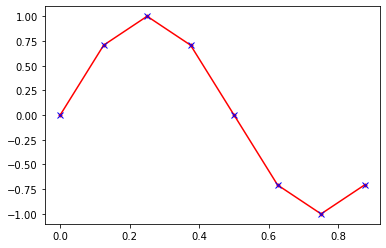

In [10]:
state = qi.Statevector.from_instruction(qc)
state_dict = state.to_dict()
data = []
n_bits = len(list(state_dict.keys())[0])
for i in list(state_dict.keys()):
    if i[n_bits-1] == '1':
        data.append(state_dict[i])
L = np.array(data)
L2 = np.angle(L)
X = np.array(range(2**n))/(2**n)
plt.plot(X,L2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')